# Luderick Object Tracking with YOLOv5 (SORT, DEEP-SORT)

## Load the preprocessed DataFrames generated in the preprocessing Notebook

In [1]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
from scipy.optimize import linear_sum_assignment

plt.style.use('ggplot')

In [2]:
# Constants
MODELS_DIR = 'models'
IMAGES_DIR = 'Fish_automated_identification_and_counting/luderick-seagrass'
VIDEOS_DIR = 'Fish_automated_identification_and_counting/videos'
CLASSES = ['luderick']
NUM_CLASSES = len(CLASSES)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
INFERENCE_OUTPUT_DIR = 'inference_outputs'
!mkdir {INFERENCE_OUTPUT_DIR}

Ya existe el subdirectorio o el archivo inference_outputs.


In [3]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array
    """
    loaded_df = pd.read_csv(file_path)
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [4]:
validation_df = load_luderick_df('luderick_validation_preprocessed.csv')
test_df = load_luderick_df('luderick_test_preprocessed.csv')

validation_df

image_name        video_name  frame_number  \
0           04C2_Luderick_16_000400.jpg  04C2_Luderick_16             1   
1           04C2_Luderick_16_000600.jpg  04C2_Luderick_16             2   
2           04C2_Luderick_16_000800.jpg  04C2_Luderick_16             3   
3           04C2_Luderick_16_001000.jpg  04C2_Luderick_16             4   
4           04C2_Luderick_16_001200.jpg  04C2_Luderick_16             5   
..                                  ...               ...           ...   
819  C1_Luderick_14.mov_5fps_000013.jpg    C1_Luderick_14            13   
820  C1_Luderick_14.mov_5fps_000014.jpg    C1_Luderick_14            14   
821  C1_Luderick_14.mov_5fps_000015.jpg    C1_Luderick_14            15   
822  C1_Luderick_14.mov_5fps_000016.jpg    C1_Luderick_14            16   
823            brim.mov_5fps_000002.jpg              brim             1   

     number_boxes        labels  \
0               1           [1]   
1               1           [1]   
2               1           [1]   
3               1           [1]   
4               1           [1]   
..            ...           ...   
819             3     [1, 1, 1]   
820             3     [1, 1, 1]   
821             4  [1, 1, 1, 1]   
822             3     [1, 1, 1]   
823             1           [1]   

                                        bounding_boxes  \
0                                 [[2, 581, 163, 755]]   
1                                 [[2, 586, 223, 765]]   
2                                 [[0, 589, 281, 760]]   
3                                 [[2, 588, 339, 748]]   
4                                 [[2, 580, 380, 746]]   
..                                                 ...   
819  [[414, 235, 701, 432], [1584, 449, 1868, 590],...   
820  [[320, 254, 573, 449], [1457, 310, 1714, 451],...   
821  [[1455, 476, 1737, 611], [1397, 304, 1697, 444...   
822  [[214, 314, 372, 504], [1325, 303, 1703, 442],...   
823                             [[329, 565, 432, 663]]   

                             area  \
0                         [28014]   
1                         [39559]   
2                         [48051]   
3                         [53920]   
4                         [62748]   
..                            ...   
819         [56539, 40044, 24924]   
820         [49335, 36237, 42000]   
821  [38070, 42000, 12314, 40425]   
822         [30020, 52542, 38676]   
823                       [10094]   

                                          segmentation  
0    [[163, 703, 146, 678, 125, 649, 93, 620, 58, 6...  
1    [[223, 711, 218, 728, 195, 731, 131, 746, 107,...  
2    [[281, 703, 279, 722, 237, 732, 165, 751, 98, ...  
3    [[339, 700, 307, 711, 276, 726, 232, 737, 220,...  
4    [[380, 678, 354, 646, 308, 607, 253, 581, 200,...  
..                                                 ...  
819  [[701, 235, 699, 250, 699, 273, 692, 310, 690,...  
820  [[573, 254, 573, 271, 566, 314, 560, 335, 556,...  
821  [[1716, 476, 1716, 504, 1722, 526, 1737, 570, ...  
822  [[372, 314, 370, 327, 365, 344, 355, 372, 331,...  
823  [[432, 628, 432, 622, 426, 584, 422, 579, 414,...  

[824 rows x 8 columns]

## Load YOLOv5 Model

### YOLOv5s small size model

In [5]:
model_path = f"{MODELS_DIR}/best_YOLOv5s_model_1.pt" 
model_s = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)  # local model
model_s.to(DEVICE).eval();
model_s.conf = 0.8

Using cache found in C:\Users\Ricard/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-5-8 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [6]:
# Visualize the model's prediction format
image = Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000013.jpg")
results = model_s(image)
results.print()
results.pandas().xyxy[0]

image 1/1: 1080x1920 3 ludericks
Speed: 36.0ms pre-process, 17.0ms inference, 9.0ms NMS per image at shape (1, 3, 384, 640)


xmin        ymin         xmax        ymax  confidence  class  \
0   398.483887  239.700348   696.885986  432.828796    0.943921      0   
1  1578.626709  434.846649  1870.343750  589.563599    0.928586      0   
2  1515.532227  316.405212  1720.730347  451.279633    0.903160      0   

       name  
0  luderick  
1  luderick  
2  luderick

 ## Predict Function

In [7]:
def predict(image, model):
    """
    Return, as arrays, the detection bounding boxes, labels, pred_scores and inference time in an PIL Image (RGB) using a 
    given model above a given detection_threshold.
    """ 
    start_time = time.time()
    with torch.no_grad():
        results = model(image) # get the predictions on the image
    end_time = time.time()
    inference_time = end_time - start_time
    
    # get the results as a pandas dataframe
    results_pandas = results.pandas().xyxy[0]
    
    return results_pandas, inference_time

## Function to Draw Bounding Boxes Around an Object

A bounding box has a format of [x_min, y_min, x_max, y_max]

In [8]:
def draw_boxes(results_df, image, color=(255, 0, 0)):
    """
    Returns an image array that contains the predicted bounding boxes, labels and scores
    """
    # read the image with OpenCV
    image = np.asarray(image)
    for index, row in results_df.iterrows():
        box = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                     color, 2)
        bbox_text = f"{row['name']} {str(round(row['confidence']*100, 2))}" # showing probability scores
        cv2.putText(image, bbox_text, (int(box[0]), int(box[1] - 5)),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                   lineType=cv2.LINE_AA)
    
    return image

In [9]:
def view_image(image_array):
    """
    Display the image array
    """
    image = Image.fromarray((image_array).astype(np.uint8))  # Pil Image needs the image to be in int format
    display(image)

## Linear sum assignment (Hungarian Algorithm)

In [10]:
def IOU(box_1, box_2):
    """
    Computes the Intersection Over Union (IOU) between two bounding boxes formatted as [x_min, y_min, x_max, y_max]
    """
    # get the right-most left edge between the two bounding boxes
    max_left = max(box_1[0], box_2[0])
    # get the left-most right edge between the two bounding boxes
    min_right = min(box_1[2], box_2[2])
    # compute the intersection width
    intersection_width = min_right - max_left
    
    # get the lowest top edge (y is bigger as it goes lower)
    max_top = max(box_1[1], box_2[1])
    # get the highest bottom edge
    min_bottom = min(box_1[3], box_2[3])
    # compute the intersection height
    intersection_height = min_bottom - max_top
    
    # if the boxes don't intersect, intersection_width or height will be negative
    intersection_area = max(0, intersection_width) * max(0, intersection_height)
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    # get the union area by adding the boxes areas and substracting their intersection
    union_area = box_1_area + box_2_area - intersection_area
    # get the final iou
    iou = intersection_area / union_area
    
    return iou

### Get boxes from one frame

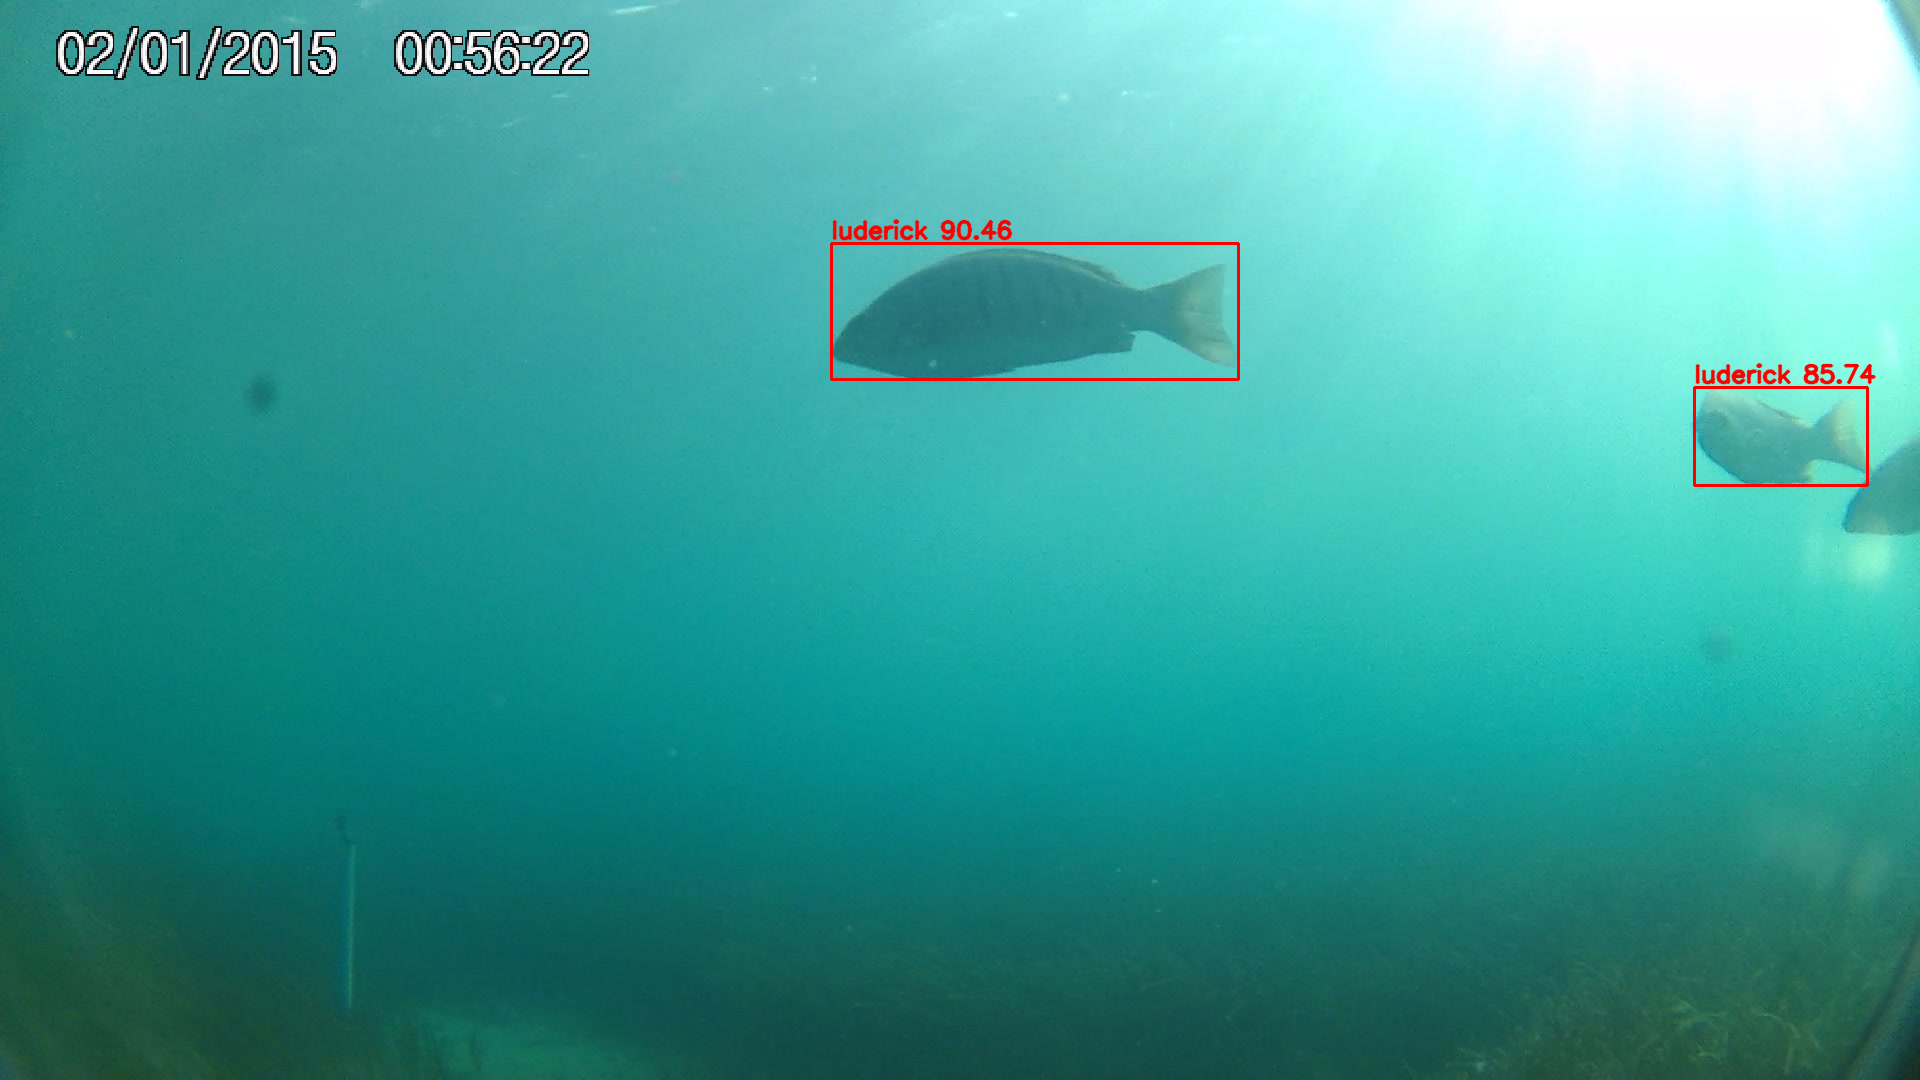

xmin        ymin         xmax        ymax  confidence  class  \
0   831.171753  243.933319  1238.248779  379.928101    0.904623      0   
1  1694.913330  387.446503  1867.797119  485.003082    0.857373      0   

       name  
0  luderick  
1  luderick

In [34]:
image_1 = Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000009.jpg").convert('RGB') 
# predict results
results_df_1, inf_time = predict(image_1, model_s)
image_boxes_1 = draw_boxes(results_df_1, image_1)
view_image(image_boxes_1)
results_df_1

### Predict boxes on next frame

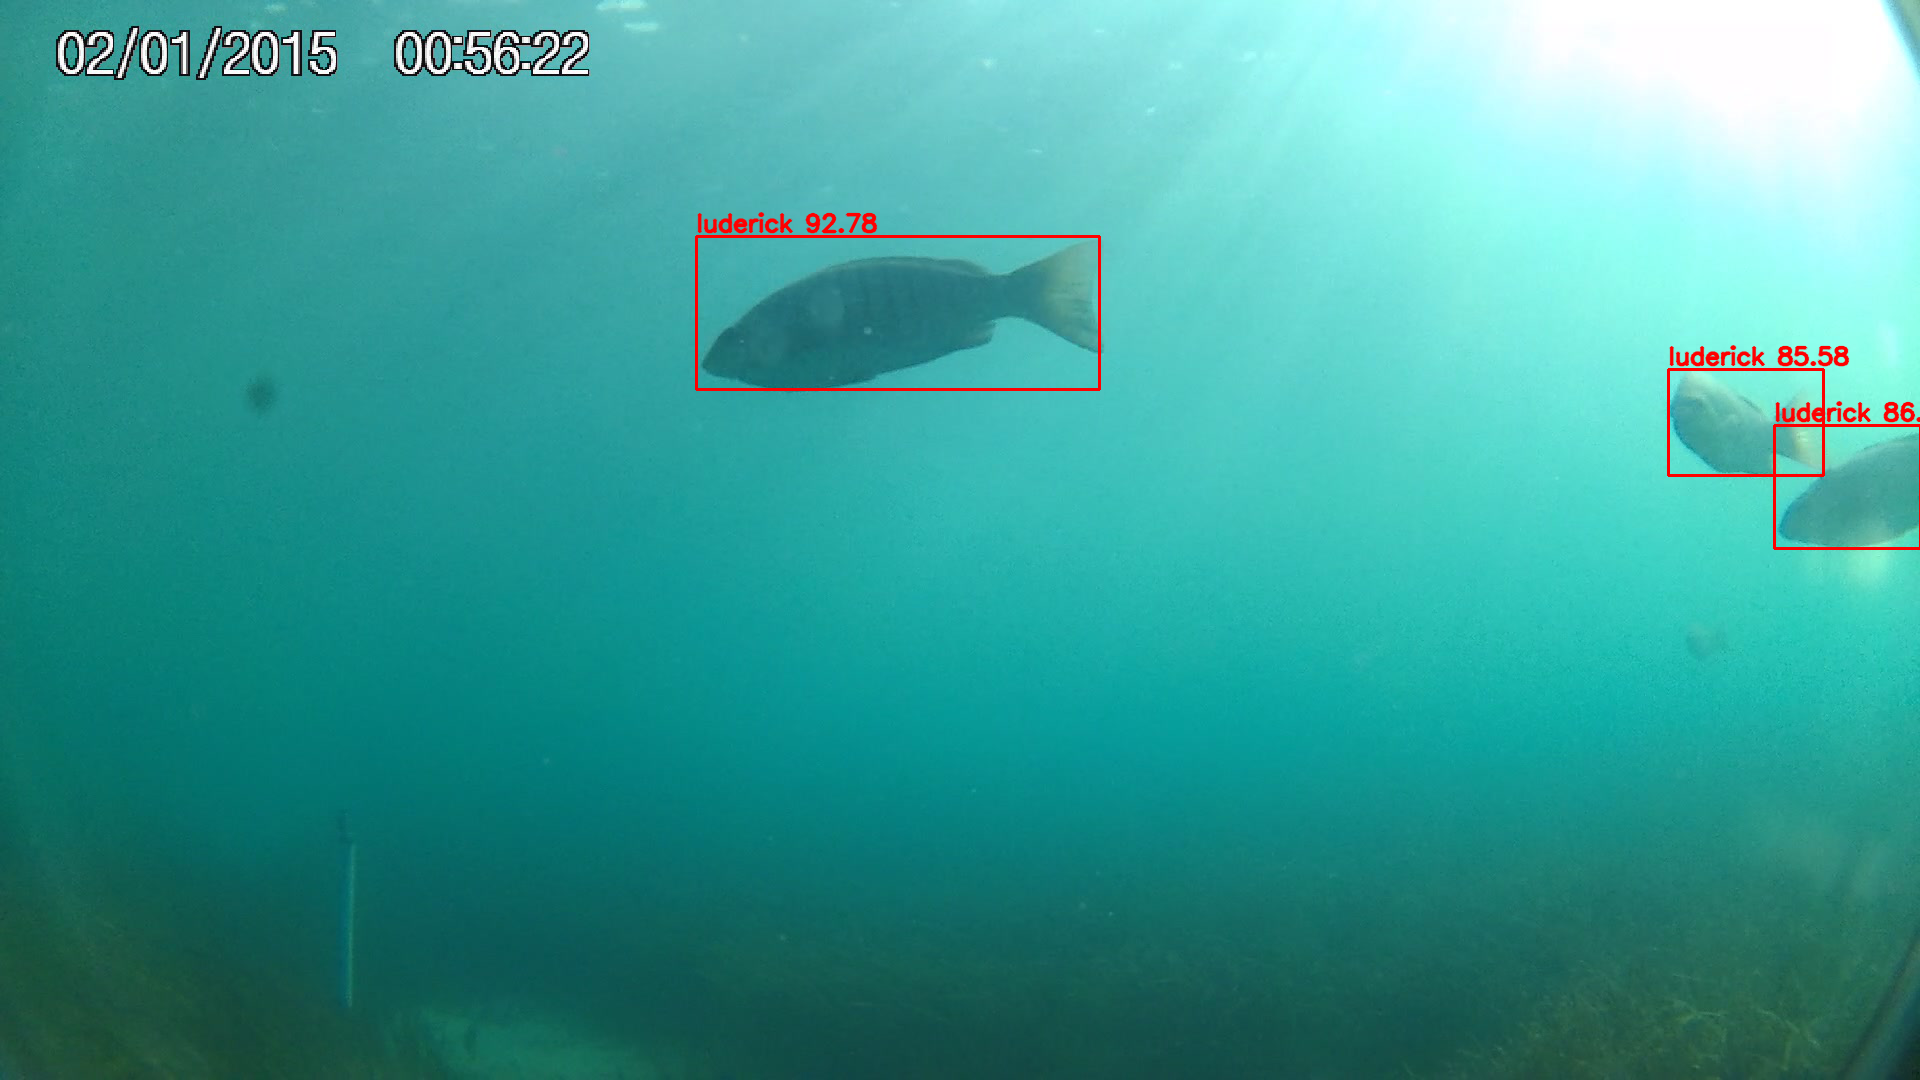

xmin        ymin         xmax        ymax  confidence  class  \
0   696.296509  236.762238  1099.279785  389.424255    0.927769      0   
1  1774.720215  425.149536  1920.000000  548.704712    0.862840      0   
2  1668.654297  369.940338  1823.660645  475.548248    0.855763      0   

       name  
0  luderick  
1  luderick  
2  luderick

In [12]:
image_2 = Image.open(f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000010.jpg").convert('RGB') 
# predict results
results_df_2, inf_time = predict(image_2, model_s)
image_boxes_2 = draw_boxes(results_df_2, image_2)
view_image(image_boxes_2)
results_df_2

### Create Cost Matrix (IOU)
For each box from the previous frame, create a row with the cost (IOU) of that box with each of the next frame boxes

In [13]:
# save the box ids from the first and second frame
old_boxes_ids = np.arange(len(results_df_1))
new_boxes_ids = np.arange(len(results_df_2))

print(f"Old boxes ids: {old_boxes_ids}")
print(f"New boxes ids: {new_boxes_ids}")
print("Old Box 0 should be linked to New box 0")
print("Old Box 1 should be linked to New box 2")

Old boxes ids: [0 1]
New boxes ids: [0 1 2]
Old Box 0 should be linked to New box 0
Old Box 1 should be linked to New box 2


In [14]:
# initialize the iou matrix with size (num old boxes, num new boxes)
iou_matrix = np.zeros((len(old_boxes_ids), len(new_boxes_ids)))
# populate the iou_matrix
for i in range(iou_matrix.shape[0]):
    # get the old box row from the results df
    old_box = results_df_1.iloc[old_boxes_ids[i]]
    # use only he coordinates
    old_box = old_box[['xmin', 'ymin', 'xmax', 'ymax']].values
    for j in range(iou_matrix.shape[1]):
        # get the new box row from the results df
        new_box = results_df_2.iloc[new_boxes_ids[j]]
        # use only he coordinates
        new_box = new_box[['xmin', 'ymin', 'xmax', 'ymax']].values
        # multiply IOU by 100 and round to get clean percentages
        iou_matrix[i,j] = round(IOU(old_box, new_box)*100)

print(iou_matrix)

[[         45           0           0]
 [          0          19          52]]


### Resolve the linear sum assignment
the linear sum assignment can be solve with the Hungarian algorithm, but i solved it using
`scipy.optimize.linear_sum_assignment` which uses a modified version of the Jonker-Volgenant algorithm, that solves the same problem

In [15]:
# use the negative iou_matrix as the algorithm tries to minimize the cost.
# setting the paramenter maximize=True lets us use the positive iou_matrix as well.
row_ids, col_ids = linear_sum_assignment(-iou_matrix)

# combine the row and col ids to get the final assignments
assignments = np.array([list(zipped) for zipped in list(zip(row_ids, col_ids))])
print(assignments)
print("Old box 0 is assigned to new box 0")
print("Old box 1 is assigned to new box 2")
print("Results are correct")

[[0 0]
 [1 2]]
Old box 0 is assigned to new box 0
Old box 1 is assigned to new box 2
Results are correct


In [16]:
# filter out assignments with lower iou than threshold and save new detections
IOU_threshold = 30
unmatched_old_boxes_ids = []
unmatched_new_boxes_ids = []
matches = []
for pair in assignments:
    # save on unmatched boxes if iou is lower than threshold
    if iou_matrix[pair[0], pair[1]] < IOU_threshold:
        unmatched_old_boxes_ids.append(pair[0])
        unmatched_new_boxes_ids.append(pair[1])
    else:
        matches.append(list(pair))
        
# find unmatched old and new detections
for old_box_id in old_boxes_ids:
    if (old_box_id not in assignments[:, 0]):
        unmatched_old_boxes_ids.append(old_box_id)
        
for new_box_id in new_boxes_ids:
    if (new_box_id not in assignments[:, 1]):
        unmatched_new_boxes_ids.append(new_box_id)
        
print('Matches:')
print(matches)
print('Unmatched old boxes:')
print(unmatched_old_boxes_ids)
print('Unmatched new boxes:')
print(unmatched_new_boxes_ids)


Matches:
[[0, 0], [1, 2]]
Unmatched old boxes:
[]
Unmatched new boxes:
[1]


### Create the tracked_object class

In [17]:
class tracked_object():
    def __init__(self, track_id, box, color, unmatched_iterations, matched_iterations):
        self.track_id = track_id
        self.box = box
        self.color = color
        self.unmatched_iterations = unmatched_iterations
        self.matched_iterations = matched_iterations

## Main Tracking Function

In [28]:
def track_new_objects(result_df, IOU_threshold, max_untracked_iterations):
    """
    Update the global variable tracked_objects using detection results from a new frame
    """
    global tracked_objects
    global track_id_iterator
    new_boxes_ids = np.arange(len(result_df))
    
    # initialize the iou matrix with size (num tracked objects, num new boxes)
    iou_matrix = np.zeros((len(tracked_objects), len(new_boxes_ids)))
    # populate the iou_matrix
    for i in range(iou_matrix.shape[0]):
        # get the old box row from the results df
        old_box = tracked_objects[i].box
        for j in range(iou_matrix.shape[1]):
            # get the new box row from the results df
            new_box = result_df.iloc[new_boxes_ids[j]]
            # use only he coordinates
            new_box = new_box[['xmin', 'ymin', 'xmax', 'ymax']].values
            # multiply IOU by 100 and round to get clean percentages
            iou_matrix[i,j] = round(IOU(old_box, new_box)*100)

    # use the negative iou_matrix as the algorithm tries to minimize the cost.
    # setting the paramenter maximize=True lets us use the positive iou_matrix as well.
    row_ids, col_ids = linear_sum_assignment(-iou_matrix)

    # combine the row and col ids to get the final assignments
    assignments = np.array([list(zipped) for zipped in list(zip(row_ids, col_ids))])

    # filter out assignments with lower iou than threshold and save new detections
    for pair in assignments:
        # save on unmatched boxes if iou is lower than threshold
        if iou_matrix[pair[0], pair[1]] < IOU_threshold:
            # update untracked_object number of unmatched iterations
            tracked_objects[pair[0]].unmatched_iterations += 1
            # remove the tracked object if it has been unmatched for X iterations
            #if tracked_objects[pair[0]].unmatched_iterations > max_untracked_iterations:
            #    tracked_objects.remove(tracked_objects[pair[0]])
        else:
            # update the tracked object
            new_box = result_df.iloc[new_boxes_ids[pair[1]]]
            new_box = new_box[['xmin', 'ymin', 'xmax', 'ymax']].values
            # update tracked_object
            tracked_objects[pair[0]].box = new_box
            tracked_objects[pair[0]].matched_iterations += 1
            tracked_objects[pair[0]].unmatched_iterations = 0

    # find unmatched old detections and delete if has been unmatched for X iterations
    for index, old_track in enumerate(tracked_objects):
        if (len(assignments) == 0 or index not in assignments[:, 0]):
            # update untracked_object number of unmatched iterations
            tracked_objects[index].unmatched_iterations += 1
        # remove the tracked object if it has been unmatched for X iterations
        if tracked_objects[index].unmatched_iterations > max_untracked_iterations:
            tracked_objects.remove(tracked_objects[index])

    # find unmatched new detections
    for new_box_id in new_boxes_ids:
        if (len(assignments) == 0 or new_box_id not in assignments[:, 1]):
            # create new tracked object with random color
            new_box = result_df.iloc[new_box_id]
            new_box = new_box[['xmin', 'ymin', 'xmax', 'ymax']].values
            new_tracked = tracked_object(track_id = track_id_iterator,
                                         box = new_box,
                                         color = np.random.uniform(0, 255, size=3),
                                         unmatched_iterations = 0,
                                         matched_iterations = 0)
            tracked_objects.append(new_tracked)
            # increase the id iterator
            track_id_iterator += 1

### Track drawing function

In [29]:
def draw_image_tracks(image, tracks):
    """
    Draws bounding boxes from image tracks
    """
    
    # read the image with OpenCV
    image = np.asarray(image)
    for track in tracks:
        # only draw tracks that have been matched this iteration
        if track.unmatched_iterations == 0:
            box = track.box
            color = track.color
            cv2.rectangle(image,
                         (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                         color, 4)
            bbox_text = f"{track.track_id}"
            cv2.putText(image, bbox_text, (int(box[0]), int(box[1] - 5)),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                       lineType=cv2.LINE_AA)
    return image

### Track ludericks in 3 consecutive frames

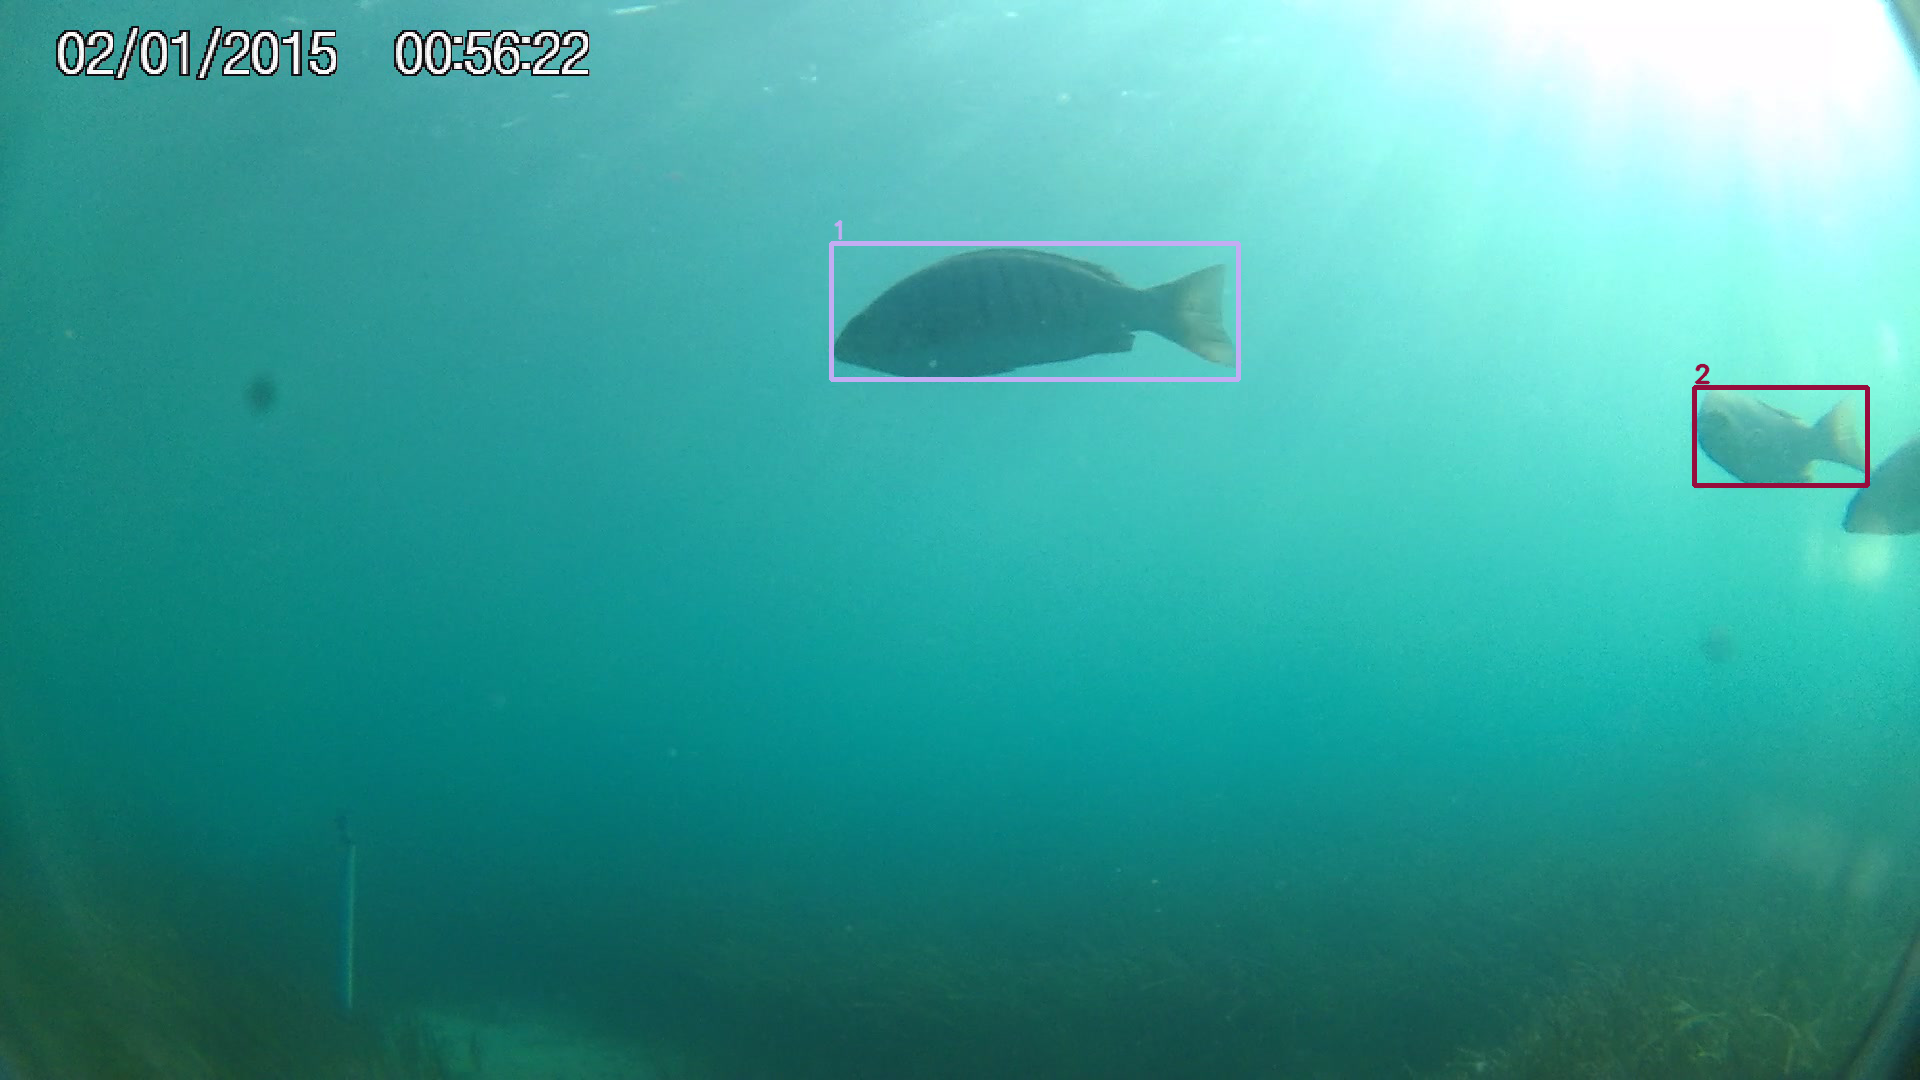

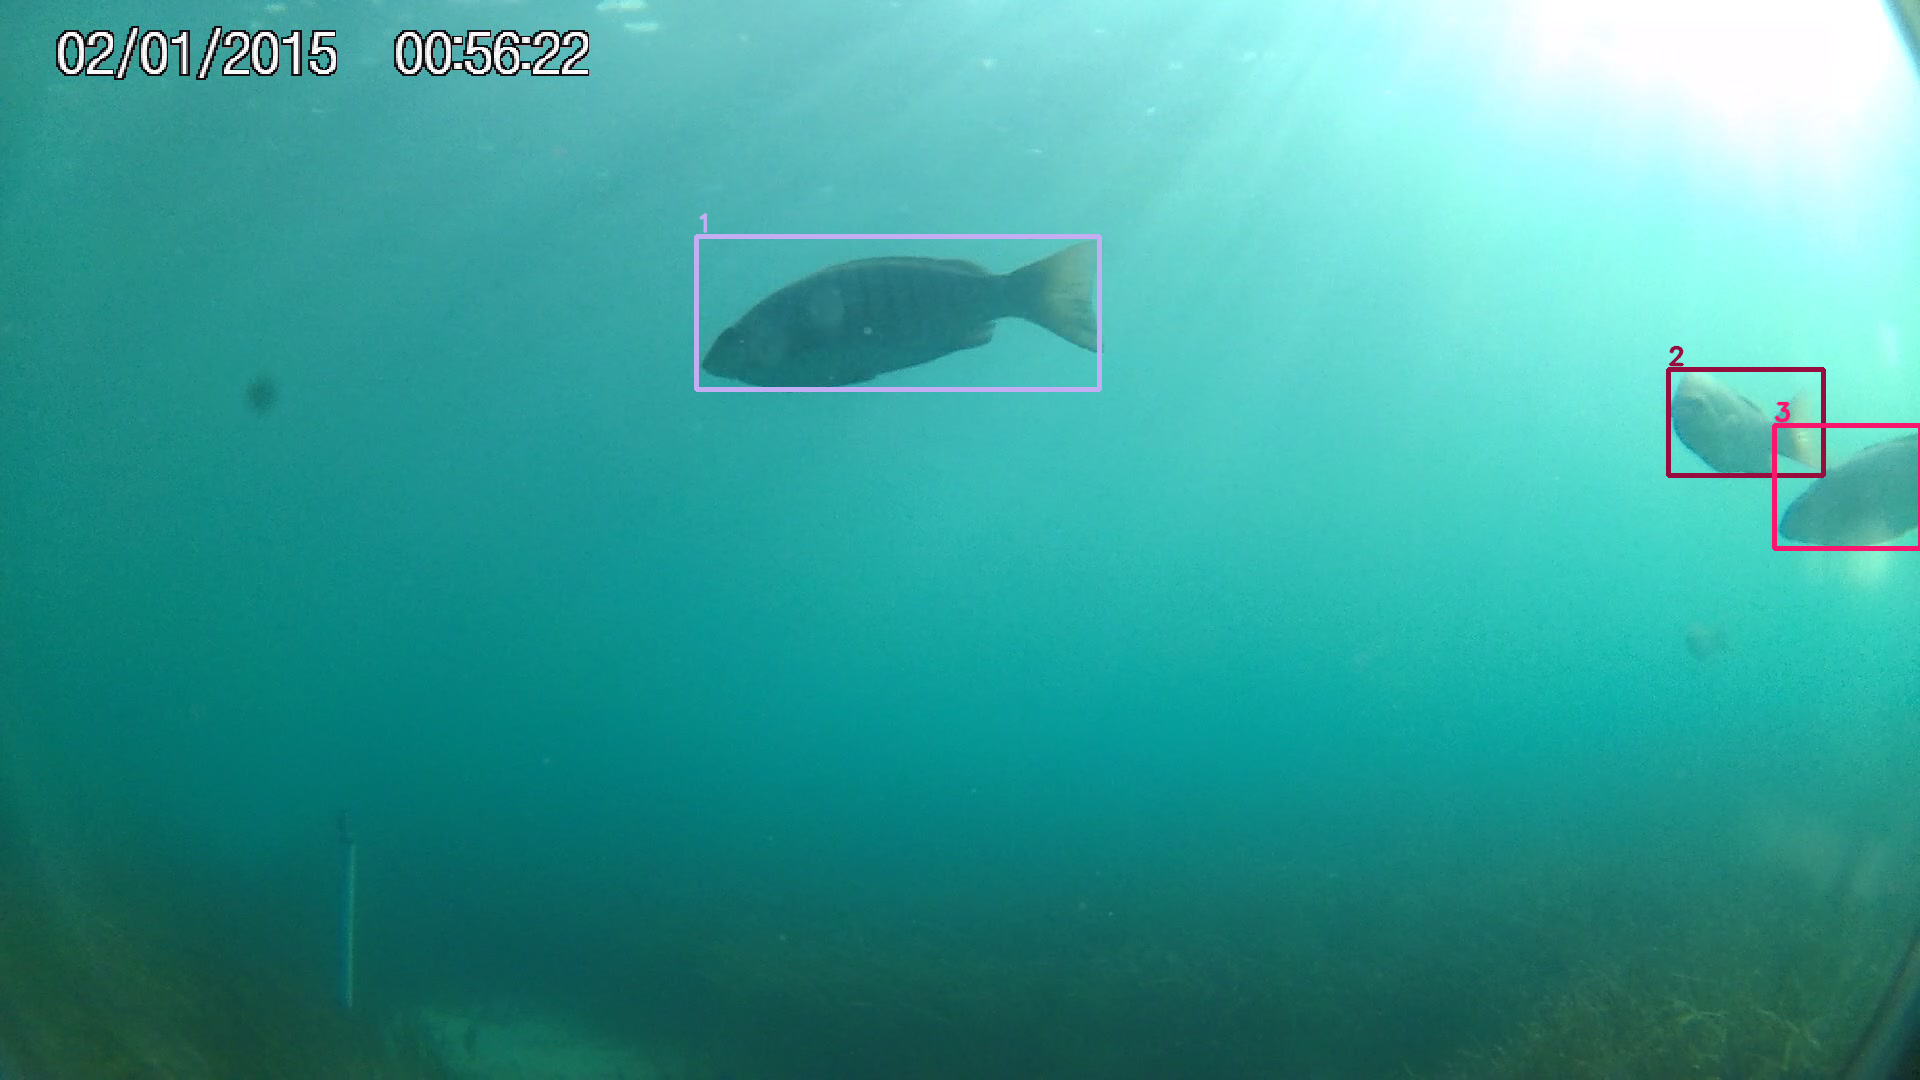

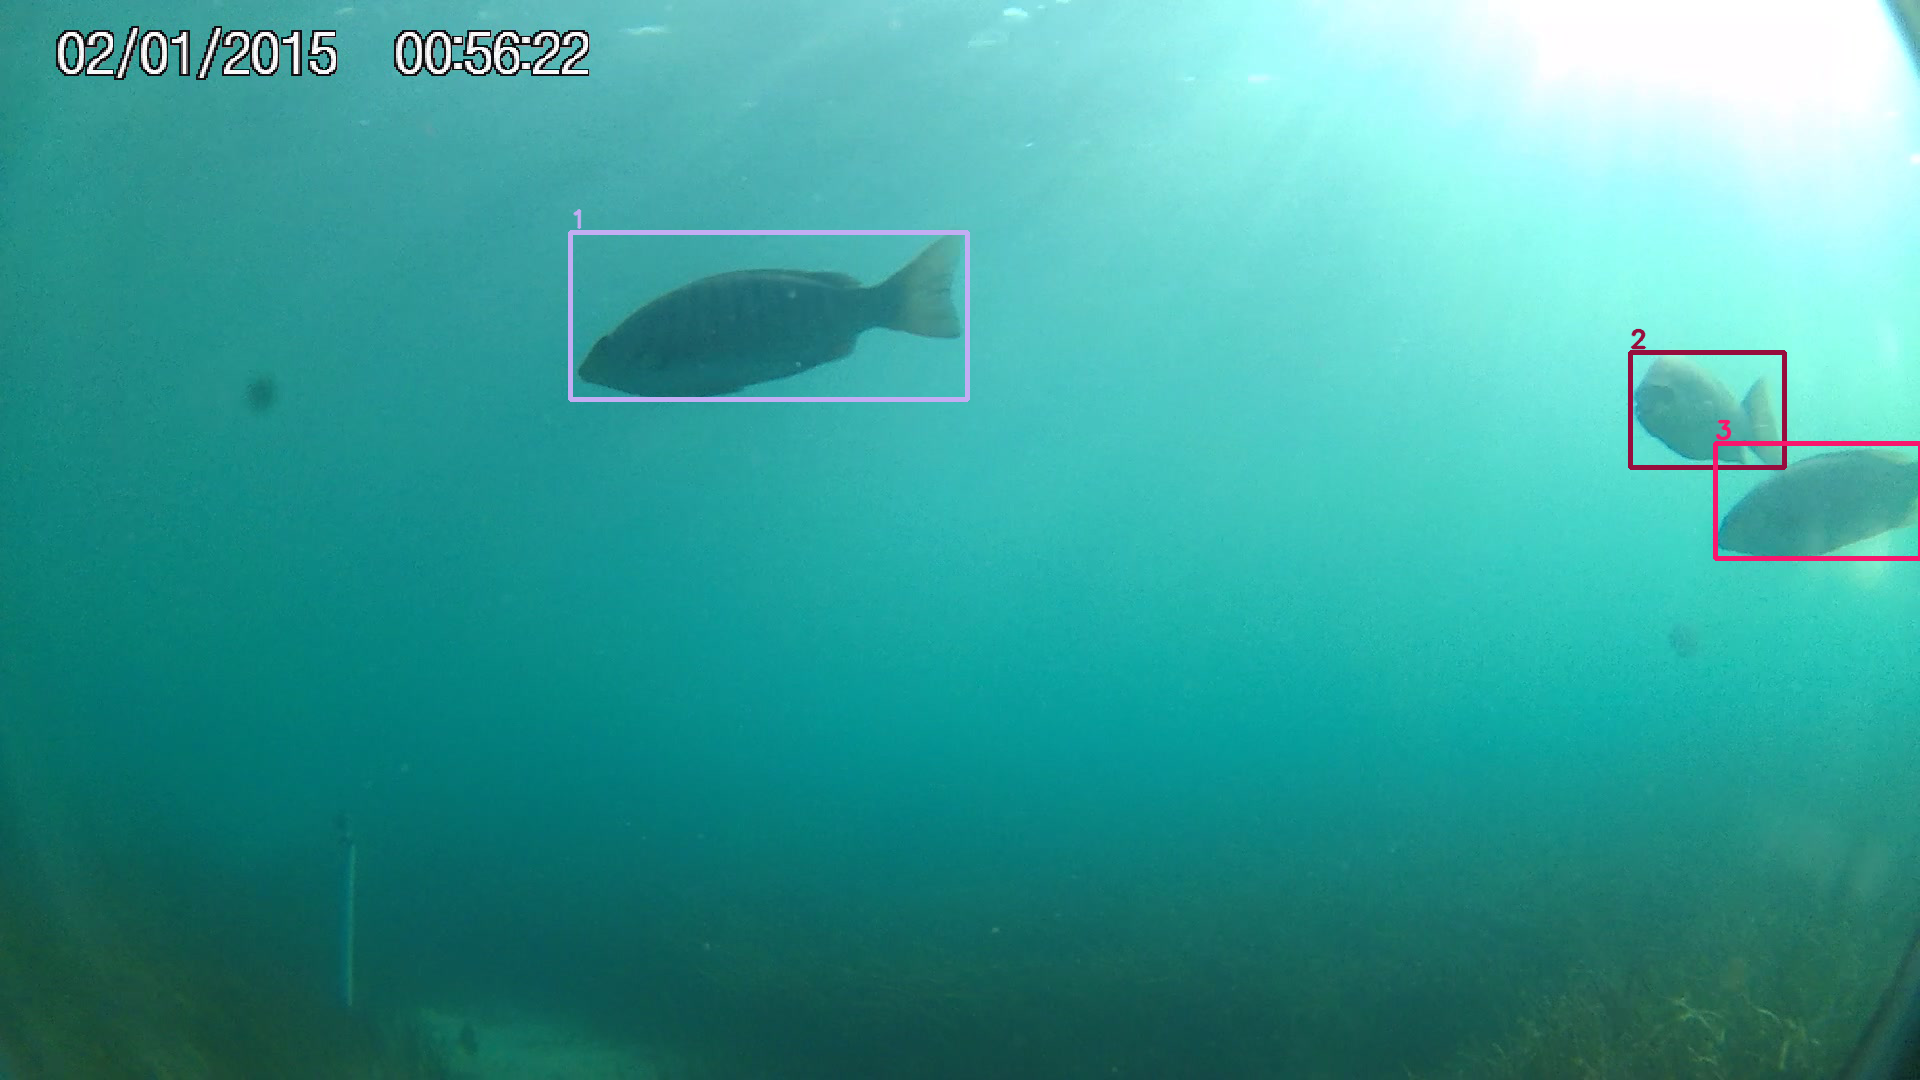

In [35]:
# track ludericks on 3 frames
image_paths = [
    f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000009.jpg",
    f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000010.jpg",
    f"{IMAGES_DIR}/C1_Luderick_14.mov_5fps_000011.jpg"
]

tracked_objects = []
track_id_iterator = 1
# iterate over the images
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB') 
    # predict boxes with YOLOv5
    results_df, inf_time = predict(image, model_s)
    # update tracks
    track_new_objects(results_df, IOU_threshold = 30, max_untracked_iterations = 2)
    # draw image tracks
    image = draw_image_tracks(image, tracked_objects)
    #display image
    view_image(image)

## Tracking on videos

In [36]:
def detect_and_track_video(video_path, model, output_dir='.', 
                           detection_threshold=0.8, save_video=True, 
                           track_IOU_threshold=30, max_untracked_iterations=2):
    """
    Carries out detection and tracking on a video frame by frame, showing it in real time in an opencv window and showing 
    the framerate. It also saves the video at 30 fps as a .mp4
    """
    # set model confidence score threshold
    model.conf = detection_threshold
    # start videocaptures
    cap = cv2.VideoCapture(video_path)
    
    if (cap.isOpened() == False):
        print('Error while trying to read video. Please check path again')
    
    # get the frame width and height
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    
    save_name = f"{video_path.split('/')[-1].split('.')[0]}"
    # define codec and create VideoWriter object
    if save_video:
        out = cv2.VideoWriter(f"{output_dir}/{save_name}.mp4",
                             cv2.VideoWriter_fourcc(*'mp4v'), 30,
                             (frame_width, frame_height))
    
    frame_count = 0 # to count total frames
    total_fps = 0 # to get the final frames per second
    
    # Reading Frames and Detecting Objects
    # read until end of video
    while(cap.isOpened()):
        # capture each frame of the video
        ret, frame = cap.read()
        # while the video isn't finished...
        if ret:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # record the fps including tracking functions
            start_time = time.time()
            with torch.no_grad():
                # get predictions for the current frame
                results_df, inf_time = predict(image, model)
            
            # update tracks
            track_new_objects(results_df, IOU_threshold = 30, max_untracked_iterations = 2)
            end_time = time.time()
            # draw image tracks and show current frame on screen
            image = draw_image_tracks(image, tracked_objects)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # get the  fps including tracking
            fps = 1 / (end_time - start_time)
            # add fps tot total fps
            total_fps += fps
            # increment frame count
            frame_count += 1
            
            # Display frames in a window
            image = cv2.putText(image, f"{fps:.1f} FPS", 
                        (image.shape[1]-200, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 
                        2, lineType=cv2.LINE_AA)
            
            # press 'q' to exit
            wait_time = max(1, int(fps/4))
            cv2.imshow('image', image)
            if save_video:
                out.write(image)
            if cv2.waitKey(wait_time) & 0xFF == ord('q'):
                break
                
        else:
            break
      
    # release VideoCapture()
    cap.release()
    # close all frames and video windows
    cv2.destroyAllWindows()
    
    # calculate and print the average fps
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}")

### YOLOV5s small model

In [38]:
folder_name = 'tracking_video_YOLOv5s_simple'
%cd {INFERENCE_OUTPUT_DIR}
!mkdir {folder_name}
%cd ..
video_path = f"{VIDEOS_DIR}/validation/2205_Luderick_25.mov"
output_dir = f"{INFERENCE_OUTPUT_DIR}/{folder_name}"

#initialize tracking variables
tracked_objects = []
track_id_iterator = 1

detect_and_track_video(video_path, model_s, output_dir, detection_threshold=0.7, save_video=True)
torch.cuda.empty_cache()

C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass\inference_outputs
C:\Users\Ricard\Desktop\Master\TFM\notebooks\Luderick_Seagrass


Ya existe el subdirectorio o el archivo tracking_video_YOLOv5s_simple.


Average FPS: 23.633


### Average FPS: 23.633